In [1]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import pickle
import time
import cv2
import os

In [2]:
# paths
base_path = 'E:/Data/Video_Frame_Interpolation/raw/vimeo_triplet'
sequences_path = 'E:/Data/Video_Frame_Interpolation/raw/vimeo_triplet/sequences'
target_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k'
train_indices = 'tri_trainlist.txt'
test_indices = 'tri_testlist.txt'

# parameters
train_limit = 50000
test_limit = None
train_2_valid_split = 49.5/50.0
size =  (256, 144)
interpolation = cv2.INTER_CUBIC

## Create proper TFRecords files

In [3]:
def preprocess(img, size, interpolation):
    img = cv2.resize(img, size, interpolation=interpolation)
    return (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0).astype('float32')

In [4]:
def bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [5]:
def sample_example(imgs):
    feature = {
        'image_1': bytes_feature(imgs[0].tobytes()),
        'image_2': bytes_feature(imgs[1].tobytes()),
        'image_3': bytes_feature(imgs[2].tobytes()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
def create_paths(file_path, limit=None, split=None):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    postfixes = [line.strip() for line in lines]
    random.shuffle(postfixes)
    if limit is not None:
        postfixes = postfixes[0:limit]
        
    if split is not None:
        index = int(len(postfixes) * split)
        return postfixes[0:index], postfixes[index:]
    else:
        return postfixes

In [7]:
def create_tf_record(base_path, paths, target_path, size, interpolation, verbose=0):
    with tf.io.TFRecordWriter(target_path) as writer:
    
        for path in tqdm(paths):
            full_path = os.path.join(base_path, path)
            try:
                imgs = []
                for name in ['im1.png', 'im2.png', 'im3.png']:
                    img_path = os.path.join(full_path, name)
                    if not os.path.exists(img_path):
                        raise FileNotFoundError(f"File {img_path} was not found")
                        
                    img = cv2.imread(img_path)
                    img = preprocess(img, size, interpolation)
                    imgs.append(img)

                tf_example = sample_example(imgs)
                writer.write(tf_example.SerializeToString())
            except FileNotFoundError as e:
                print(f"The following error occurred: {e}")

In [8]:
train_paths, validation_paths = create_paths(
    file_path = os.path.join(base_path, train_indices),
    limit = train_limit,
    split = train_2_valid_split
)
test_paths = create_paths(
    file_path = os.path.join(base_path, test_indices),
    limit = test_limit,
    split = None
)

In [9]:
creation_time = int(time.time())
create_tf_record(
    base_path = sequences_path,
    paths = train_paths, 
    target_path = os.path.join(target_path, f'train_{len(train_paths)}_{size[1]}x{size[0]}_{creation_time}.tfrecords'),
    size = size, 
    interpolation = interpolation,
    verbose = 1
)

100%|███████████████████████████████████████| 49500/49500 [1:07:13<00:00, 12.27it/s]


In [10]:
create_tf_record(
    base_path = sequences_path,
    paths = test_paths, 
    target_path = os.path.join(target_path, f'test_{len(test_paths)}_{size[1]}x{size[0]}_{creation_time}.tfrecords'),
    size = size, 
    interpolation = interpolation
)
create_tf_record(
    base_path = sequences_path,
    paths = validation_paths, 
    target_path = os.path.join(target_path, f'valid_{len(validation_paths)}_{size[1]}x{size[0]}_{creation_time}.tfrecords'),
    size = size, 
    interpolation = interpolation
)

 48%|████████████████████▋                      | 1825/3783 [02:27<01:52, 17.41it/s]

The following error occurred: File E:/Data/Video_Frame_Interpolation/raw/vimeo_triplet/sequences\im1.png was not found


100%|█████████████████████████████████████████████| 500/500 [00:37<00:00, 13.16it/s]


In [11]:
print(f'Train size: {len(train_paths)}')
print(f'Test size: {len(test_paths)}')
print(f'Validation size: {len(validation_paths)}')

Train size: 49500
Test size: 3783
Validation size: 500


## Example of reading TFRecords

In [12]:
def parse_record(record):
    name_to_features = {
        'image_1': tf.io.FixedLenFeature([], tf.string),
        'image_2': tf.io.FixedLenFeature([], tf.string),
        'image_3': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

In [13]:
def decode_record(record):
    image_1 = tf.io.decode_raw(
        record['image_1'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_1 = tf.reshape(image_1, (size[1], size[0], 3))
    
    image_2 = tf.io.decode_raw(
        record['image_2'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_2 = tf.reshape(image_2, (size[1], size[0], 3))
    
    image_3 = tf.io.decode_raw(
        record['image_3'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_3 = tf.reshape(image_3, (size[1], size[0], 3))
    
    return [image_1, image_3], image_2

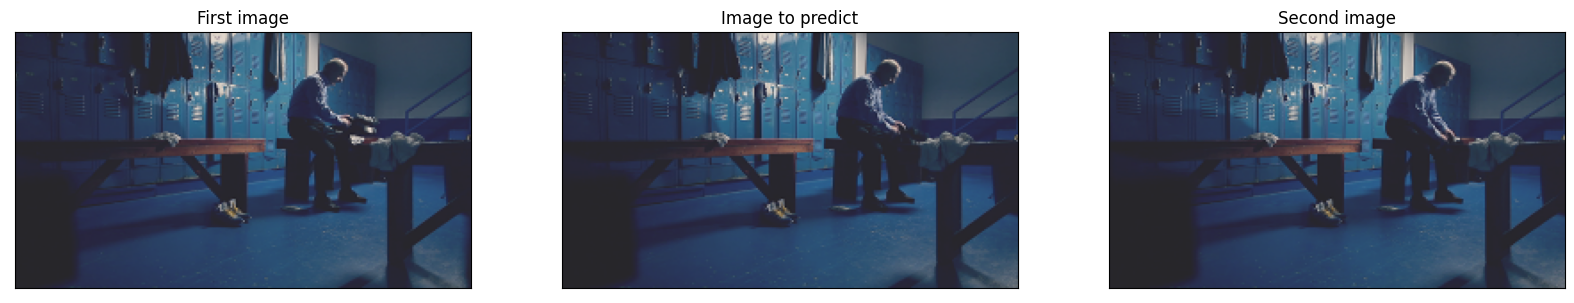

In [14]:
dataset = tf.data.TFRecordDataset(os.path.join(target_path, 'train_19000_144x256_1682372054.tfrecords'))
for record in dataset:
    parsed_record = parse_record(record)
    imgs, true = decode_record(parsed_record)
    f, ax = plt.subplots(1, 3)
    f.set_size_inches(20, 20)
    ax[0].imshow(imgs[0])        
    ax[0].set_title('First image')     
    ax[0].set_xticks([])     
    ax[0].set_yticks([])     
    ax[1].imshow(true)   
    ax[1].set_title('Image to predict')     
    ax[1].set_xticks([])     
    ax[1].set_yticks([])    
    ax[2].imshow(imgs[1])
    ax[2].set_title('Second image') 
    ax[2].set_xticks([])     
    ax[2].set_yticks([])    
    break